In [1]:
!pip install torchinfo
!nvidia-smi

Fri Jul  5 11:55:17 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   58C    P8             10W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
# import
import numpy as np
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import torchinfo
import os
from pytz import timezone

# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]= "0,1"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)  # 출력결과: cuda

if DEVICE.type == "cuda":
    print("Count of using GPUs:", torch.cuda.device_count())
    print("Current cuda device:", torch.cuda.current_device())
    print("Memory Allocated:", round(torch.cuda.memory_allocated(0) / 1024**3, 1), "GB")

    print("Memory Cached:", round(torch.cuda.memory_reserved(0) / 1024**3, 1), "GB")

Device: cpu


In [2]:
# 하이퍼파라미터 설정
RANDOM_SEED = 4242
LEARNING_RATE = 0.01
BATCH_SIZE = 64
EPOCHS = 40
IMG_SIZE = 224
NUM_CLASSES = 10

# 규제화 파라미터 설정
DROPOUT = 0.5

In [3]:
# 모델의 정확도를 계산하는 함수
def get_accuracy(model, data_loader, device):
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        model.eval()
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            probabilities = F.softmax(model(images), dim=-1)
            _, predicted_labels = torch.max(probabilities, 1)

            total_predictions += labels.size(0)
            correct_predictions += (predicted_labels == labels).sum()
    return correct_predictions.float() / total_predictions

In [4]:
# 학습 손실과 검증 손실을 시각화
def plot_loss(train_loss, val_loss):
    plt.style.use("grayscale")
    train_loss = np.array(train_loss)
    val_loss = np.array(val_loss)
    fig, ax = plt.subplots(1, 1, figsize=(8, 4.5))
    ax.plot(train_loss, color="green", label="Training Loss")
    ax.plot(val_loss, color="red", label="Validation Loss")
    ax.set(title="Loss Over Epochs", xlabel="EPOCH", ylabel="LOSS")
    ax.legend()
    fig.show()
    plt.style.use("default")

In [5]:
# 모델 학습 함수
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        loss = criterion(logits, labels)
        total_loss += loss.item() * images.size(0)
        loss.backward()
        optimizer.step()
    epoch_loss = total_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [6]:
# 검증 데이터셋을 사용하여 모델의 성능을 평가
def validate(valid_loader, model, criterion, device):
    model.eval()
    total_loss = 0

    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        # 순전파와 손실 기록하기
        logits = model(images)
        loss = criterion(logits, labels)
        total_loss += loss.item() * images.size(0)

    epoch_loss = total_loss / len(valid_loader.dataset)
    return model, epoch_loss

In [7]:
# 전체 학습 루프
def training_loop(
    model,
    criterion,
    optimizer,
    train_loader,
    valid_loader,
    epochs,
    device,
    print_every=1,
):
    train_losses = []
    valid_losses = []
    print(
        datetime.now(timezone("Asia/Seoul")).time().replace(microsecond=0),
        "--- Start Training Loop ---",
    )

    for epoch in range(epochs):
        # training
        model, optimizer, train_loss = train(
            train_loader, model, criterion, optimizer, device
        )
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):

            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)

            print(
                datetime.now(timezone("Asia/Seoul")).time().replace(microsecond=0),
                "--- ",
                f"Epoch: {epoch}\t"
                f"Train loss: {train_loss:.4f}\t"
                f"Valid loss: {valid_loss:.4f}\t"
                f"Train accuracy: {100 * train_acc:.2f}\t"
                f"Valid accuracy: {100 * valid_acc:.2f}",
            )

    plot_loss(train_losses, valid_losses)

    return model, optimizer, (train_losses, valid_losses)

In [9]:
# Inception 모듈 정의
class InceptionModule(nn.Module):
    def __init__(
        self, in_dim, out_dim1, pre_dim3, out_dim3, pre_dim5, out_dim5, out_dim_pool
    ):
        super(InceptionModule, self).__init__()
        # branch 1x1
        self.conv1x1 = nn.Conv2d(in_dim, out_dim1, kernel_size=1)
        # branch 3x3
        self.conv3x3_pre = nn.Conv2d(in_dim, pre_dim3, kernel_size=1)
        self.conv3x3 = nn.Conv2d(pre_dim3, out_dim3, kernel_size=3, padding=1)
        # branch 5x5
        self.conv5x5_pre = nn.Conv2d(in_dim, pre_dim5, kernel_size=1)
        self.conv5x5 = nn.Conv2d(pre_dim5, out_dim5, kernel_size=5, padding=2)
        # branch pooling
        self.pool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.pool_after = nn.Conv2d(in_dim, out_dim_pool, kernel_size=1)

    def forward(self, x):
        out1x1 = F.relu(self.conv1x1(x))
        out3x3 = F.relu(self.conv3x3(F.relu(self.conv3x3_pre(x))))
        out5x5 = F.relu(self.conv5x5(F.relu(self.conv5x5_pre(x))))
        out_pool = F.relu(self.pool_after(self.pool(x)))
        return torch.cat([out1x1, out3x3, out5x5, out_pool], 1)


# GoogLeNet 모델 파트 A 정의
class GoogLeNetPartA(nn.Module):
    def __init__(self):
        super(GoogLeNetPartA, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        return x


# GoogLeNet 모델 파트 B 정의
class GoogLeNetPartB(nn.Module):
    def __init__(self):
        super(GoogLeNetPartB, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.inception3a = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        self.inception4a = InceptionModule(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionModule(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionModule(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionModule(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionModule(528, 256, 160, 320, 32, 128, 128)
        self.inception5a = InceptionModule(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionModule(832, 384, 192, 384, 48, 128, 128)

    def forward(self, x):
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.pool(x)
        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.pool(x)
        x = self.inception5a(x)
        x = self.inception5b(x)
        return x


# GoogLeNet 모델 파트 C 정의
class GoogLeNetPartC(nn.Module):
    def __init__(self):
        super(GoogLeNetPartC, self).__init__()
        self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
        self.dropout = nn.Dropout(DROPOUT)
        self.fc = nn.Linear(1024, NUM_CLASSES)

    def forward(self, x):
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


# GoogLeNet 모델 정의
class GoogLeNet(nn.Module):
    def __init__(self):
        super(GoogLeNet, self).__init__()
        self.part1 = GoogLeNetPartA()
        self.part2 = GoogLeNetPartB()
        self.part3 = GoogLeNetPartC()

    def forward(self, x):
        x = self.part1(x)
        x = self.part2(x)
        x = self.part3(x)
        return x


torchinfo.summary(
    GoogLeNet(),
    input_size=(1, 3, IMG_SIZE, IMG_SIZE),
    col_names=["input_size", "output_size", "num_params", "kernel_size"],
    row_settings=["depth", "var_names"],
)

Layer (type (var_name):depth-idx)                  Input Shape               Output Shape              Param #                   Kernel Shape
GoogLeNet (GoogLeNet)                              [1, 3, 224, 224]          [1, 10]                   --                        --
├─GoogLeNetPartA (part1): 1-1                      [1, 3, 224, 224]          [1, 192, 28, 28]          --                        --
│    └─Conv2d (conv1): 2-1                         [1, 3, 224, 224]          [1, 64, 112, 112]         9,472                     [7, 7]
│    └─MaxPool2d (pool): 2-2                       [1, 64, 112, 112]         [1, 64, 56, 56]           --                        3
│    └─Conv2d (conv2): 2-3                         [1, 64, 56, 56]           [1, 192, 56, 56]          110,784                   [3, 3]
│    └─MaxPool2d (pool): 2-4                       [1, 192, 56, 56]          [1, 192, 28, 28]          --                        3
├─GoogLeNetPartB (part2): 1-2                      [1, 192, 

In [10]:
# transforms 정의하기
transform = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE),),
        transforms.RandomHorizontalFlip(),  # 50% 확률로 수평 뒤집기
        transforms.ToTensor(),
    ]
)

# 데이터셋 다운로드 및 생성
train_dataset = datasets.CIFAR10(
    root="cifar10_data", train=True, transform=transform, download=True
)

valid_dataset = datasets.CIFAR10(root="cifar10_data", train=False, transform=transform)

# 데이터 로더 정의
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# 불러온 데이터 확인
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure(figsize=(10, 5))  # 창 크기 조정
for i, (image, label) in enumerate(train_loader):
    if i == ROW_IMG * N_ROWS:
        break
    ax = plt.subplot(N_ROWS, ROW_IMG, i + 1)
    ax.axis("off")
    # 이미지 표시하기
    plt.imshow(transforms.ToPILImage()(image[0]))

fig.suptitle("CIFAR10 Dataset - preview")
plt.show()


# 데이터셋 크기 출력
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(valid_dataset)}")

URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1007)>

20:55:35 --- Start Training Loop ---
21:07:51 ---  Epoch: 0	Train loss: 1.5251	Valid loss: 1.3788	Train accuracy: 55.26	Valid accuracy: 54.80
21:20:10 ---  Epoch: 1	Train loss: 0.9590	Valid loss: 0.9375	Train accuracy: 68.67	Valid accuracy: 67.12
21:32:30 ---  Epoch: 2	Train loss: 0.7667	Valid loss: 0.7267	Train accuracy: 78.31	Valid accuracy: 75.06
21:44:50 ---  Epoch: 3	Train loss: 0.6346	Valid loss: 0.6538	Train accuracy: 82.19	Valid accuracy: 77.87
21:57:09 ---  Epoch: 4	Train loss: 0.5505	Valid loss: 0.6936	Train accuracy: 81.83	Valid accuracy: 77.30
22:09:24 ---  Epoch: 5	Train loss: 0.4676	Valid loss: 0.5499	Train accuracy: 87.47	Valid accuracy: 81.61
22:21:42 ---  Epoch: 6	Train loss: 0.4003	Valid loss: 0.5054	Train accuracy: 90.97	Valid accuracy: 83.40
22:34:02 ---  Epoch: 7	Train loss: 0.3480	Valid loss: 0.4785	Train accuracy: 92.03	Valid accuracy: 83.52
22:46:21 ---  Epoch: 8	Train loss: 0.2950	Valid loss: 0.5342	Train accuracy: 92.52	Valid accuracy: 83.40
22:58:42 ---  Epoc

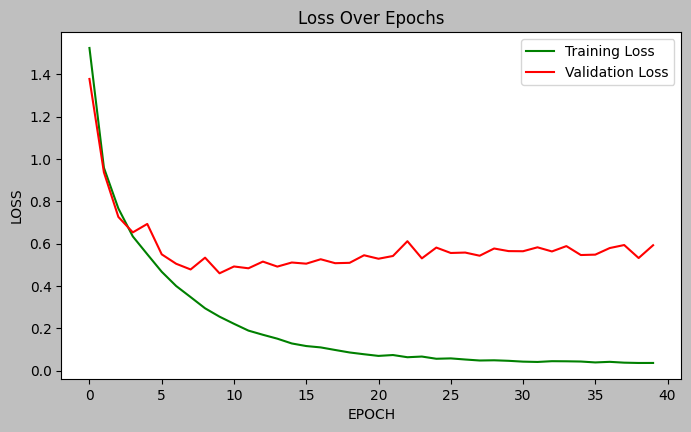

In [11]:
torch.manual_seed(RANDOM_SEED)

_model = GoogLeNet().cuda()
model = nn.DataParallel(_model).to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
for param_group in optimizer.param_groups:
    param_group['weight_decay'] = 0.01 / 40

criterion = nn.CrossEntropyLoss()

model, optimizer, _ = training_loop(
    model, criterion, optimizer, train_loader, valid_loader, EPOCHS, DEVICE
)